# Exercise 1 part 1
Using a generalized linear model analyzed Poisson distributed data set named 'discrete_regression_data.csv' (applying Stan).

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from cmdstanpy import set_cmdstan_path, cmdstan_path
set_cmdstan_path('/home/jaqb/Documents/cmdstan-2.26.1')
cmdstan_path()

'/home/jaqb/Documents/cmdstan-2.26.1'

In [3]:
df = pd.read_csv('discrete_regression_data.csv',index_col=0)
df.describe()

,x_1,x_2,x_3,y
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.001349,0.328014,-0.008712,8.640000
std,0.573010,0.294522,0.369813,4.115256
min,-0.997592,0.000008,-0.992794,0.000000
25%,-0.501613,0.054107,-0.126214,6.000000
50%,-0.012899,0.251657,-0.000002,8.000000
75%,0.501155,0.547333,0.125869,11.000000
max,0.999151,0.998302,0.997455,28.000000


All of variables $x_1$, $x_2$ and $x_3$ are real. $x_1$ and $x_3$ values are from -1 to 1, and $x_2$ values are from 0 to 1, $y$ variable has only integer values from 0 to 28.

Model looks like this: $$y\sim \textrm{Poisson}(\lambda)$$
$$\lambda = \textrm{exp}(\theta) $$ $$\theta = \beta_1x_1 + \beta_2x_2 +\beta_3x_3 + \alpha$$ $$\beta_1, \beta_2, \beta_3 \sim \textrm{Normal}(0, \sigma)$$ $$\alpha \sim \textrm{Normal}(0, \sigma)$$

#### Prior predictive checks

In [4]:
with open('model_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real x1[N];
  real x2[N];
  real x3[N];
  real<lower=0> sigma;
}

generated quantities {
  real alpha = normal_rng(0,sigma);
  real beta1 = normal_rng(0,sigma);
  real beta2 = normal_rng(0,sigma);
  real beta3 = normal_rng(0,sigma);
  real y[N];
  for (i in 1:N) {
    y[i] = poisson_log_rng(x1[i]*beta1+x2[i]*beta2+x3[i]*beta3+alpha,sigma);
  }
}



In [9]:
model_prior_checks = CmdStanModel(stan_file='model_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab6/model_ppc
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab6/model_ppc


Trying rather flat prior with $\sigma$=10: 

In [125]:
data_prior_checks = dict(N=len(df),
                         x1=df.x_1.values,
                         x2=df.x_2.values,
                         x3=df.x_3.values,
                         sigma=10)

sim_prior_checks=model_prior_checks.sample(data=data_prior_checks, 
                           iter_sampling=1000, iter_warmup=0, 
                           chains=1,
                           fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [126]:
beta1 = sim_prior_checks.stan_variable('beta1')
beta2 = sim_prior_checks.stan_variable('beta2')
beta3 = sim_prior_checks.stan_variable('beta3')
alpha = sim_prior_checks.stan_variable('alpha')

In [127]:
params=np.hstack((np.array([beta1]).T, np.array([beta2]).T, np.array([beta3]).T, np.array([alpha]).T))

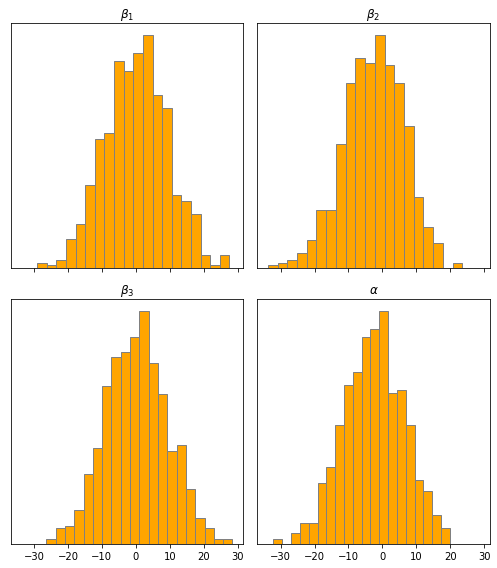

In [129]:
fig, axes = plt.subplots(2, 2, figsize=(7, 8), squeeze=False,sharex=True)
axes_flat=axes.flatten()
names_of_pars = [r'$\beta_1$',r'$\beta_2$',r'$\beta_3$',r'$\alpha$']
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(params[:,k],bins=20,color='orange',edgecolor='grey',density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

In [130]:
y_prior_checks = sim_prior_checks.stan_variable('y')

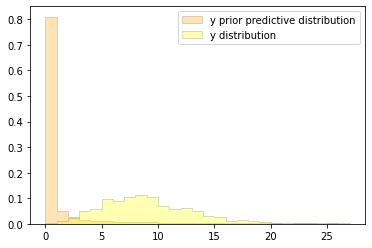

In [131]:
plt.hist(y_prior_checks.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0,28,1), density=True)
plt.hist(df.y, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0,28,1))
plt.legend(["y prior predictive distribution", "y distribution"])
plt.show()

In [132]:
np.nanmax(y_prior_checks)

998495000.0

Parameters are mostly limited to the range (-20, 20), but because their product with input data is exponentiated, corresponding y values can be very large (even though most of y values are 0).

Trying priors with smaller $\sigma$=0,5:

In [146]:
data_prior_checks = dict(N=len(df),
                         x1=df.x_1.values,
                         x2=df.x_2.values,
                         x3=df.x_3.values,
                         sigma=0.5)

sim_prior_checks=model_prior_checks.sample(data=data_prior_checks, 
                           iter_sampling=1000, iter_warmup=0, 
                           chains=1,
                           fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [147]:
beta1 = sim_prior_checks.stan_variable('beta1')
beta2 = sim_prior_checks.stan_variable('beta2')
beta3 = sim_prior_checks.stan_variable('beta3')
alpha = sim_prior_checks.stan_variable('alpha')

In [148]:
params=np.hstack((np.array([beta1]).T, np.array([beta2]).T, np.array([beta3]).T, np.array([alpha]).T))

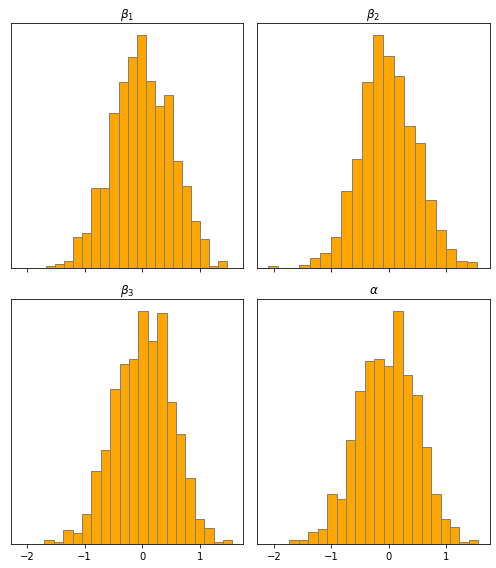

In [149]:
fig, axes = plt.subplots(2, 2, figsize=(7, 8), squeeze=False,sharex=True)
axes_flat=axes.flatten()
names_of_pars = [r'$\beta_1$',r'$\beta_2$',r'$\beta_3$',r'$\alpha$']
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(params[:,k],bins=20,color='orange',edgecolor='grey',density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

In [150]:
y_prior_checks = sim_prior_checks.stan_variable('y')

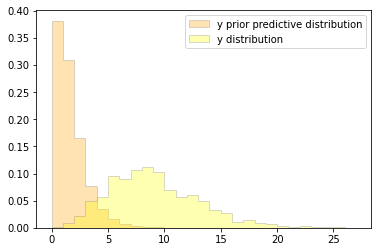

In [151]:
plt.hist(y_prior_checks.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0,28,1), density=True)
plt.hist(df.y, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0,28,1))
plt.legend(["y prior predictive distribution", "y distribution"])
plt.show()

In [152]:
np.nanmax(y_prior_checks)

43.0

Lower value of $\sigma$=0.5 resulted in parameters being mostly limited to the range (-1, 1). This set appropriate bounds to the values of y, now having the biggest value of 43.

#### Posterior inference

In [168]:
with open('model.stan', 'r') as file:
    print(file.read())

data {
  int<lower=0> N;
  vector[N] x1;
  vector[N] x2;
  vector[N] x3;
  int y[N];
}

parameters {
  real alpha;
  real beta1;
  real beta2;
  real beta3;
}

transformed parameters {
  vector[N] lambda = x1*beta1+x2*beta2+x3*beta3+alpha;
}

model {
  beta1 ~ normal(0, 0.5);
  beta2 ~ normal(0, 0.5);
  beta3 ~ normal(0, 0.5);
  alpha ~ normal(0, 0.5);

  y ~ poisson(exp(lambda));
}

generated quantities {
  int y_ppc[N];
  for (i in 1:N) {
    y_ppc[i] = poisson_rng(exp(lambda[i]));
  }
}


In [157]:
model = CmdStanModel(stan_file='model.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab6/model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab6/model


In [158]:
data_fit = dict(N=len(df),
                x1=df.x_1.values,
                x2=df.x_2.values,
                x3=df.x_3.values,
                y=df.y.values)

fit = model.sample(data=data_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [162]:
beta1 = fit.stan_variable('beta1')
beta2 = fit.stan_variable('beta2')
beta3 = fit.stan_variable('beta3')
alpha = fit.stan_variable('alpha')

In [163]:
params=np.hstack((np.array([beta1]).T, np.array([beta2]).T, np.array([beta3]).T, np.array([alpha]).T))

Inferred distributions of parameters:

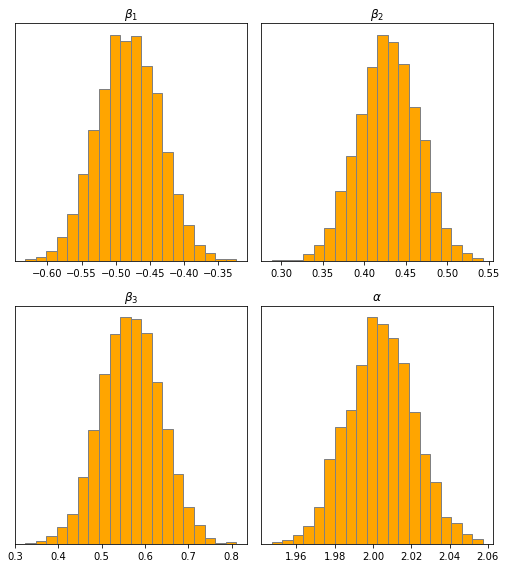

In [166]:
fig, axes = plt.subplots(2, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
names_of_pars = [r'$\beta_1$',r'$\beta_2$',r'$\beta_3$',r'$\alpha$']
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(params[:,k],bins=20,color='orange',edgecolor='grey',density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

In [171]:
az.summary(fit,var_names=['beta1','beta2','beta3','alpha'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
beta1,-0.48,0.05,-0.57,-0.40
beta2,0.43,0.04,0.36,0.49
beta3,0.57,0.07,0.44,0.70
alpha,2.00,0.02,1.97,2.04


In [169]:
y_predicted = fit.stan_variable('y_ppc')

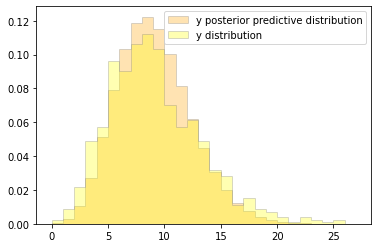

In [172]:
plt.hist(y_predicted.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0,28,1), density=True)
plt.hist(df.y, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0,28,1))
plt.legend(["y posterior predictive distribution", "y distribution"])
plt.show()

There are differences in posterior predictive distribution of the data and real data.

# Exercise 1 part 2
Determine the model's dispersion parameter and interpret the obtained result.

Second model was created using negative binomial distribution with dispersion parameterization. Such distribution has 2 parameters: $\mu$-mean and $\psi$=$\phi^{-1}$-dispersion. When $\psi$=0, then negative binomial distribution is just Poisson distribution.
Model looks like this: $$y\sim \textrm{Negative Binomial}(\textrm{exp}(\mu), \phi^{-1})$$ $$\mu = \beta_1x_1 + \beta_2x_2 +\beta_3x_3 + \alpha$$ $$\beta_1, \beta_2, \beta_3 \sim \textrm{Normal}(0, 0.5)$$ $$\alpha \sim \textrm{Normal}(0, 0.5)$$ $$\phi^{-1}\sim\textrm{Exponential}(1) $$

In [5]:
with open('model_nb.stan', 'r') as file:
    print(file.read())

data {
  int<lower=0> N;
  vector[N] x1;
  vector[N] x2;
  vector[N] x3;
  int y[N];
}

parameters {
  real alpha;
  real beta1;
  real beta2;
  real beta3;
  real<lower=0> inv_phi;
}

transformed parameters {
  real<lower=0> phi = 1 / inv_phi;
}

model {
  beta1 ~ normal(0, 0.5);
  beta2 ~ normal(0, 0.5);
  beta3 ~ normal(0, 0.5);
  alpha ~ normal(0, 0.5);
  inv_phi ~ exponential(1);

  y ~ neg_binomial_2(exp(x1*beta1+x2*beta2+x3*beta3+alpha), phi);
}

generated quantities {
  int y_ppc[N];
  for (i in 1:N) {
    y_ppc[i] = neg_binomial_2_rng(exp(x1[i]*beta1+x2[i]*beta2+x3[i]*beta3+alpha), phi);
  }
}


In [6]:
model_nb = CmdStanModel(stan_file='model_nb.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab6/model_nb
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab6/model_nb


In [7]:
data_fit = dict(N=len(df),
                x1=df.x_1.values,
                x2=df.x_2.values,
                x3=df.x_3.values,
                y=df.y.values)
fit = model_nb.sample(data=data_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


In [8]:
beta1 = fit.stan_variable('beta1')
beta2 = fit.stan_variable('beta2')
beta3 = fit.stan_variable('beta3')
alpha = fit.stan_variable('alpha')
inv_phi = fit.stan_variable('inv_phi')
phi = fit.stan_variable('phi')

In [10]:
params=np.hstack((np.array([beta1]).T, np.array([beta2]).T, np.array([beta3]).T, np.array([alpha]).T, np.array([phi]).T, np.array([inv_phi]).T))

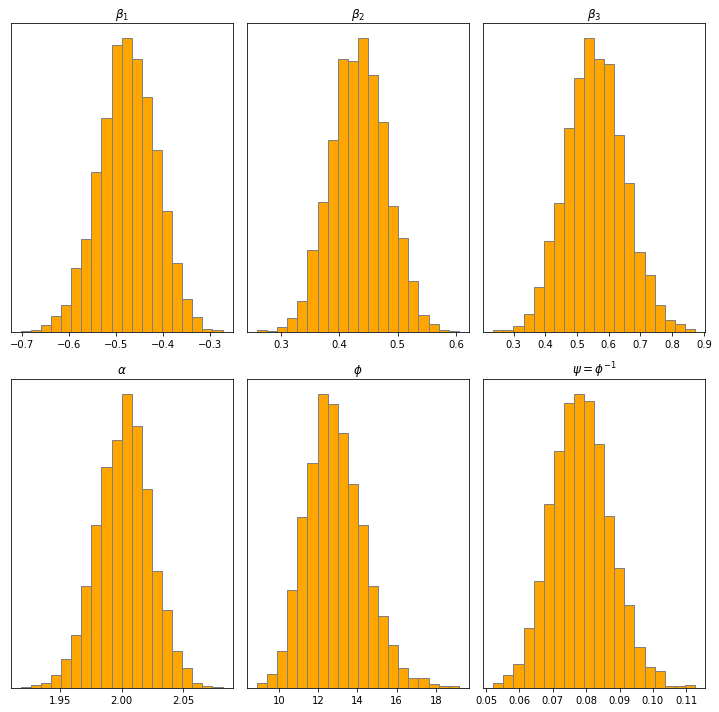

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10), squeeze=False)
axes_flat=axes.flatten()
names_of_pars = [r'$\beta_1$',r'$\beta_2$',r'$\beta_3$',r'$\alpha$',r'$\phi$',r'$\psi=\phi^{-1}$']
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(params[:,k],bins=20,color='orange',edgecolor='grey',density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

In [17]:
az.summary(fit,var_names=['beta1','beta2','beta3','alpha', 'phi', 'inv_phi'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
beta1,-0.47,0.06,-0.59,-0.37
beta2,0.43,0.05,0.35,0.52
beta3,0.56,0.09,0.39,0.73
alpha,2.00,0.02,1.96,2.04
phi,12.90,1.47,10.35,15.70
inv_phi,0.08,0.01,0.06,0.09


In [18]:
y_predicted = fit.stan_variable('y_ppc')

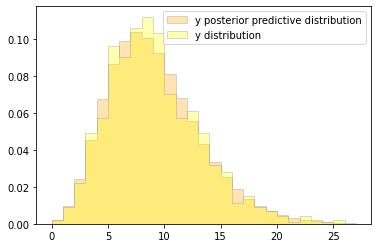

In [19]:
plt.hist(y_predicted.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0,28,1), density=True)
plt.hist(df.y, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0,28,1))
plt.legend(["y posterior predictive distribution", "y distribution"])
plt.show()

With negative binomial distribution model, data generated by posterior distributions of parameters resemble real data more precisely. Dispersion has a posterior distribution with 0.94 highest density interval of [0.06, 0.09] and mean 0.08.